<a href="https://colab.research.google.com/github/AstouK/PFMS---Healthcare-Analytics-II/blob/main/Hospital_Patient_LOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Business Understanding and Objective

### Topic Overview: healthcare Analysis

* Problem statement: e.g., “Predict the expected length of stay (LOS) in days for inpatients based on demographics, diagnoses, and treatments.”
* Business/clinical context: Why it matters (e.g., resource allocation, discharge planning).

### Objective


## 2. Data Understanding
Goal: Load and inspect the raw data.
You’d do:
* Import libraries (pandas, numpy, matplotlib, etc.)
* Load datasets (.csv, SQL, or hospital data warehouse)
* Display sample rows, column info, and data types (df.info(), df.describe())

Why: You need to understand what data you have, how it’s structured, and whether it’s suitable for the task.


### 2.1 Loading Data and Imports

In [ ]:
#Installing necessary packages (not included in Google collab)
!pip install ogboost

In [ ]:
# Import Drive to access csv file on google collab (remove before submitting file)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CORE LIBRARIES
import numpy as np
import pandas as pd

# DATA VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns

# DATA PREPROCESSING
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# MACHINE LEARNING MODELS
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from ogboost import GradientBoostingOrdinal  # ordinal classification model

#SPLITTING DATA SETS INTO TRAINING AND VALIDATION SETS
from sklearn.model_selection import train_test_split

# MODEL EVALUATION METRICS
from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    confusion_matrix,
)


In [ ]:
df = pd.read_csv("/content/Topic3_healthcare_analytics_dataset.csv")
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/Topic3_healthcare_analytics_dataset.csv'

### 2.2 Inspecting Data

In [ ]:
df.shape

(455495, 18)

In [ ]:
# case_id should be unique. Checking that there is no duplicate:

df['case_id'].is_unique

True

In [ ]:
df.dtypes

,0
case_id,int64
Hospital_code,int64
Hospital_type_code,object
City_Code_Hospital,int64
Hospital_region_code,object
Available Extra Rooms in Hospital,int64
Department,object
Ward_Type,object
Ward_Facility_Code,object
Bed Grade,float64


We have mostly categorical features, except Admission Deposit and available extra room. These numerical features might need to be normilized to not skew the ML models results.

Note: some of these columns have a numerical type but are in fact categorical variables, so their type should be changed to object to be more exact (Hospital_code for example).

In [ ]:
df.describe()

,case_id,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Visitors with Patient,Admission_Deposit
count,455495.00000,455495.000000,455495.000000,455495.000000,455347.000000,455495.000000,448806.000000,455495.000000,455495.000000
mean,227748.00000,18.326335,4.767798,3.196140,2.628420,65786.793563,7.249495,3.284229,4877.434022
std,131490.22477,8.634036,3.102450,1.166994,0.871997,37968.830850,4.758941,1.768044,1084.982089
min,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1800.000000
25%,113874.50000,11.000000,2.000000,2.000000,2.000000,32874.000000,4.000000,2.000000,4184.000000
50%,227748.00000,19.000000,5.000000,3.000000,3.000000,65735.000000,8.000000,3.000000,4738.000000
75%,341621.50000,26.000000,7.000000,4.000000,3.000000,98576.500000,8.000000,4.000000,5405.000000
max,455495.00000,32.000000,13.000000,24.000000,4.000000,131624.000000,38.000000,32.000000,11920.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 455495 entries, 0 to 455494
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            455495 non-null  int64  
 1   Hospital_code                      455495 non-null  int64  
 2   Hospital_type_code                 455495 non-null  object 
 3   City_Code_Hospital                 455495 non-null  int64  
 4   Hospital_region_code               455495 non-null  object 
 5   Available Extra Rooms in Hospital  455495 non-null  int64  
 6   Department                         455495 non-null  object 
 7   Ward_Type                          455495 non-null  object 
 8   Ward_Facility_Code                 455495 non-null  object 
 9   Bed Grade                          455347 non-null  float64
 10  patientid                          455495 non-null  int64  
 11  City_Code_Patient                  4488

## 3. Exploratory Data Analysis (EDA)

Goal: Understand data patterns, distributions, and relationships.
You’d do:
* Univariate analysis: distributions of LOS, age, diagnosis codes, etc.
* Bivariate analysis: correlation between LOS and features (e.g., comorbidities, lab results)
* Identify outliers or anomalies.
* Visualizations (histograms, boxplots, correlation heatmaps).

Why: EDA helps you spot trends and data quality issues early — it informs feature engineering later.

### 3.1 Target Analysis
Check distribution of each feature

#### Hospital Stay Duration Distribution

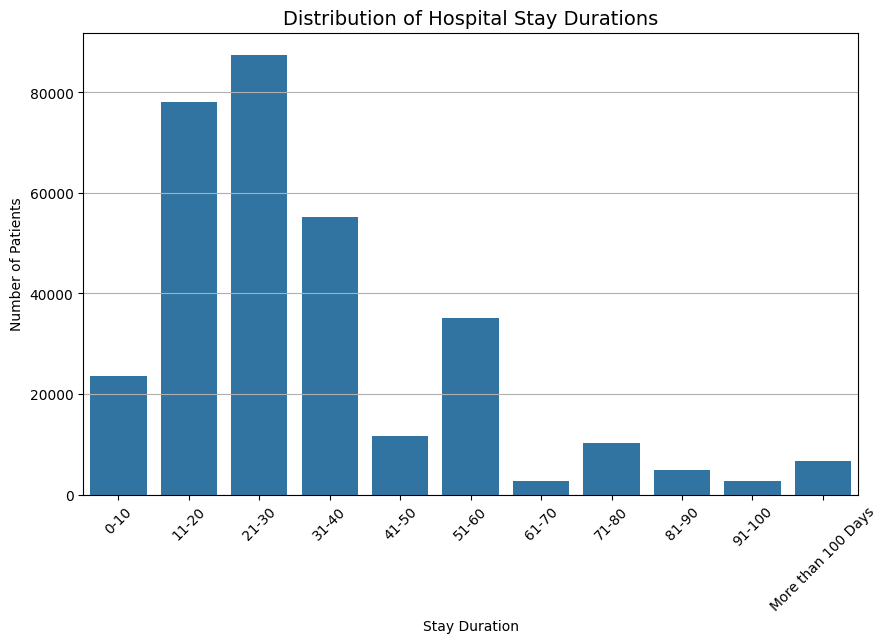

In [ ]:
#Define the order of categories in 'Stay'.
stay_order = ['0-10', '11-20', '21-30', '31-40', '41-50',
              '51-60', '61-70', '71-80', '81-90', '91-100', 'More than 100 Days']

df['Stay'] = pd.Categorical(df['Stay'], categories=stay_order, ordered=True)

#Distribution of target variable 'stay'. Checking for imbalance.
plt.figure(figsize=(10, 6))
sns.countplot(x='Stay', data=df, order=stay_order)
plt.title("Distribution of Hospital Stay Durations", fontsize=14)
plt.xlabel("Stay Duration")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [ ]:
(df["Stay"].value_counts(normalize=True) * 100).round(2).astype(str) + "%"

,proportion
Stay,
21-30,27.48%
11-20,24.54%
31-40,17.32%
51-60,11.0%
0-10,7.41%
41-50,3.69%
71-80,3.22%
More than 100 Days,2.1%
81-90,1.52%


Insights:

### 3.2 Bivariate Analysis

#### Admission Deposit

TypeError: can't multiply sequence by non-int of type 'float'

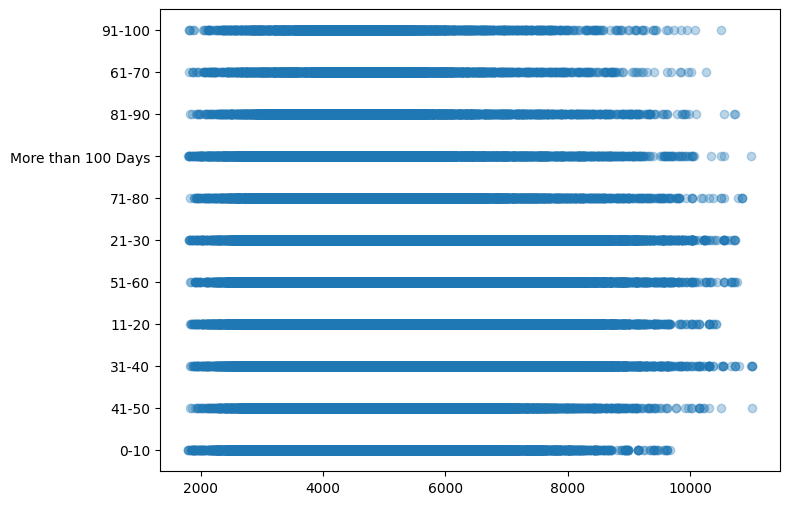

In [ ]:
plt.figure(figsize=(8,6))
sns.regplot(x='Admission_Deposit', y='Stay', data=df, scatter_kws={'alpha':0.3})
plt.title('Admission Deposit vs Stay')
plt.xlabel('Admission Deposit')
plt.ylabel('Stay (encoded)')
plt.show()

#### Patient Age

In [ ]:
#Explore if patient age impacts length of stay.
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age', y='Stay', data=df)
plt.title("Age Group vs Stay Duration", fontsize=14)
plt.xlabel("Age Group")
plt.ylabel("Stay Duration")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Severity of Illness

In [ ]:
#Explore how illness severity impact.
plt.figure(figsize=(10, 6))
sns.boxplot(x='Severity of Illness', y='Stay', data=df)
plt.title("Illness Severity vs Stay Duration", fontsize=14)
plt.xlabel("Severity")
plt.ylabel("Stay Duration")
plt.grid(True)
plt.tight_layout()
plt.show()


#### Admission Type

In [ ]:
#Explore how Admission type affects LOS.
plt.figure(figsize=(10, 6))
sns.boxplot(x='Type of Admission', y='Stay', data=df)
plt.title("Admission Type vs Stay Duration", fontsize=14)
plt.xlabel("Admission Type")
plt.ylabel("Stay Duration")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Correlation Matrix

In [ ]:
#Correlation matrix to see relation between target variable 'Stay' and numeric values.
plt.figure(figsize=(14, 10))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.tight_layout()
plt.show()

### 3.3 Checking for Missing values

In [ ]:
df.isna().sum()


It seems only 'Bed Grade' and 'City_Code_Patient' have missing values. Since these are categorical features, handling by imputation of mode seems the most efficient choice.

In [ ]:
# Check which replacement option for missing 'Bed Grade' is best to use --> mode

df['Bed Grade'].describe()
df['Bed Grade'].hist()

In [ ]:
# Check which replacement option for missing 'City_Code_Patient' is best to use -- mode

df['City_Code_Patient'].describe()
df['City_Code_Patient'].hist()

### 3.4 Checking for Outliers

In [ ]:
# Identifing which numerical date have outliers

import seaborn as sns
import matplotlib.pyplot as plt

numeric_cols = ['Available Extra Rooms in Hospital', 'Visitors with Patient', 'Admission_Deposit', 'Stay']

plt.figure(figsize=(12,6))
sns.boxplot(data=df[numeric_cols])
plt.title("Boxplot of Numeric Columns (Outliers Shown)")
plt.xticks(rotation=45)
plt.show()

In [ ]:

numeric_cols = ['Admission_Deposit']

# Convert columns to float (in case some are object type)
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

# Identify rows with outliers
outliers = df[((df[numeric_cols] < Q1 - 1.5*IQR) | (df[numeric_cols] > Q3 + 1.5*IQR)).any(axis=1)]
print("Rows with outliers:")
print(outliers)

# Number of rows with outliers
print("Number of rows with outliers:", len(outliers))

# Number of outliers per column
outlier_flags = (df[numeric_cols] < Q1 - 1.5*IQR) | (df[numeric_cols] > Q3 + 1.5*IQR)
print("Number of outlier values per column:")
print(outlier_flags.sum())

In [ ]:
# We found outliers, but we should at the beginning check how relevant this category is (correletion)

## 4. Data Cleaning & Preprocessing
Goal: Make the dataset ready for modeling.
You’d do:
* Handle missing values (e.g., imputation strategies).
* Remove or cap outliers (e.g., extreme LOS values).
* Convert categorical features (diagnosis codes, department) using one-hot encoding or embeddings.
* Normalize/scale numerical features if needed.
* Split data into train/test (or train/val/test) sets.

Why: Garbage in = garbage out. Clean, well-prepared data is crucial for model performance and fairness.


#### 4.1 Split Data into Test and Validation Sets

In [ ]:
df.columns

In [ ]:
# Select Target variable to predict and make sure data type is correct (categorical variable)
y = df['Stay'].astype('object')

# Select Features for prediction, all except:
# - Target to be predicted ('Stay')
# - ID-like columns to avoid data-leakage, namely 'case_id' and 'patientid'
features_columns = [col for col in df.columns if col not in ['Stay', 'case_id', 'patientid']]
X = df[features_columns]

# Set categorical features data types as object
categorical_cols = [
    'Hospital_code', 'Hospital_type_code', 'City_Code_Hospital',
    'Hospital_region_code', 'Department', 'Ward_Type',
    'Ward_Facility_Code', 'Bed Grade', 'City_Code_Patient',
    'Type of Admission', 'Severity of Illness', 'Age'
]

# Convert these columns to object type in-place
X[categorical_cols] = X[categorical_cols].astype('object')

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### 4.2 Target Data Preparation

#### Missing Values
FYI: We need to remove missing values in the target variable of training and validation data before feeding it to a machine learning model because the model relies on having a known output (target) to learn from (Chatgpt).

In [ ]:
# Check if any missing values in training data
print("Any missing values in y_train:", y_train.isnull().any().any())
print("Any missing values in X_train:", X_train.isnull().any().any())

# Drop rows with missing target in the training set
train_mask = y_train.notnull()  # True for rows where y_train is not NaN
X_train = X_train[train_mask] # Replace X_train with only values that verify the mask, ie values that are not null
y_train = y_train[train_mask]

# Drop rows with missing target in the validation set
val_mask = y_val.notnull()      # True for rows where y_val is not NaN
X_val = X_val[val_mask]
y_val = y_val[val_mask]

# Optional sanity check
print("Training set size after dropping NaNs in target:", X_train.shape[0])
print("Validation set size after dropping NaNs in target:", X_val.shape[0])
print("Any missing values left in y_train?", y_train.isnull().any())
print("Any missing values left in y_val?", y_val.isnull().any())

#### Categorical Data Ordinal Encoding
FYI: Target variable here needs to be encoded ordinally (categorical variable with "ranking", like 0-10 days stay < 11-20 days stay etc.) before being inputed into the models. We replace the ranges with number from 0 to 10.

In [ ]:
# Ensure y_train and y_val have no missing values
y_train = y_train[y_train.notnull()]
y_val = y_val[y_val.notnull()]

# Initialize the encoder
target_encoder = OrdinalEncoder()

# Fit on training target and transform
y_train_encoded = target_encoder.fit_transform(y_train.values.reshape(-1, 1)).ravel()

# Transform validation target
y_val_encoded = target_encoder.transform(y_val.values.reshape(-1, 1)).ravel()

# Optional: check mapping
mapping = dict(zip(target_encoder.categories_[0], range(len(target_encoder.categories_[0]))))
print("Ordinal mapping of target classes:", mapping)

### 4.3 Features Proprocessing
FYI: used Pipelines here for more robust and smaller code.
Missing values in numerical feature columns are replaced with median, while missing values in categorical variables are replaced with mode.
Additionally, categorical feature columns are encoded ordinally whenever possible, using one_hot encoder otherwise.

In [ ]:
# =============================== Identify feature types ===============================
# Identify feature types (categorical vs numeric)
numeric_columns = ['Available Extra Rooms in Hospital','Visitors with Patient',
       'Admission_Deposit']
ordinal_columns = ['Bed Grade', 'Severity of Illness', 'Age']  # Add any ordinal features here if applicable
nonordinal_columns = list(set(X_train.columns) - (set(ordinal_columns) | set(numeric_columns)))

# =============================== Transformers ===============================
# Numeric: median imputation + scaling
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()) # Optional: scale numeric features
])

# Ordinal categorical: mode imputation + ordinal encoding
ordinal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

# Non-ordinal categorical: mode imputation + one-hot encoding
nonordinal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine all transformers
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns),
    ('ord', ordinal_transformer, ordinal_columns),
    ('cat', nonordinal_transformer, nonordinal_columns)
])

## 5. Model Selection & Training

### 5.1 Model selection

In [ ]:
# =============================== 🏗️ Models ===============================
models = {}

# Decision Tree (classification)
models["Decision Tree"] = Pipeline([
    ("preprocess", preprocessor),
    ("clf", DecisionTreeClassifier(max_depth=None, random_state=42))
])

# Random Forest (classification)
models["Random Forest"] = Pipeline([
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=42))
])

# OGBoost (Gradient Boosting Ordinal), better performing than XGBoost for ordinal tasks
models["OGBoost"] = Pipeline([
    ("preprocess", preprocessor),
    ("ord", GradientBoostingOrdinal(
        n_estimators=300,
        learning_rate=0.1,
        random_state=42
    ))
])

### 5.2 Model Training & Evaluation



In [ ]:
# =============================== Helper: evaluation function ===============================
def evaluate_model(name, y_true, y_pred):
    """
    Evaluate the performance of a model on ordinal/categorical predictions.

    Parameters
    ----------
    name : str
        Name of the model (used for printing and result dictionary).
    y_true : array-like of shape (n_samples,)
        True labels of the target variable.
    y_pred : array-like of shape (n_samples,)
        Predicted labels by the model.

    Returns
    -------
    dict
        A dictionary containing the model name and key evaluation metrics:
        - "Accuracy": Fraction of exact matches between y_true and y_pred.
        - "QWK": Quadratic Weighted Kappa score, measures ordinal agreement.
        - "Ordinal_MAE": Mean absolute error between predicted and true ordinal labels.

    Side Effects
    ------------
    Prints:
        - Accuracy
        - Quadratic Weighted Kappa (QWK)
        - Ordinal MAE
        - Confusion matrix (counts of true vs predicted labels)
    """
    acc = accuracy_score(y_true, y_pred)
    qwk = cohen_kappa_score(y_true, y_pred, weights="quadratic")
    mae = mean_absolute_error(y_true, y_pred)

    print(f"\n=== {name} ===")
    print(f"Accuracy:        {acc:.4f}")
    print(f"Quadratic Kappa: {qwk:.4f}")
    print(f"Ordinal MAE:     {mae:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("-" * 50)

    return {"Model": name, "Accuracy": acc,
            "QWK": qwk, "Ordinal_MAE": mae}

In [ ]:
# Convert targets to integers for ordinal regression
y_train_encoded = y_train_encoded.astype(int)
y_val_encoded   = y_val_encoded.astype(int)

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")

    # For pipelines with target encoding, fit needs X and y
    model.fit(X_train, y_train_encoded)

    # Generate predictions
    if name == "OGBoost":
        # Round and clip regression predictions to nearest class
        y_pred = np.clip(
            np.rint(model.predict(X_val)),
            y_train_encoded.min(),
            y_train_encoded.max()
        ).astype(int)
    else:
        # Random Forest and Decision Tree
        y_pred = model.predict(X_val)

    # Evaluate model
    metrics = evaluate_model(name, y_val_encoded, y_pred)
    results.append(metrics)

# ===============================📊 Results summary ===============================
results_df = pd.DataFrame(results).sort_values("QWK", ascending=False)
print("\n\n=== Summary (sorted by QWK) ===")
print(results_df)

## 6. Feature Importance & Explainability
Goal: Understand what drives predictions.
You’d do:
* Use SHAP or LIME to interpret predictions.
*	Identify top contributing features (e.g., diagnosis type, comorbidities, age).
*	Discuss whether the model aligns with medical intuition.

Why: Interpretability is critical in healthcare — clinicians and administrators need to trust the model.



## 7. Conclusion & Recommendations
Goal: Summarize findings and insights.
You’d include:
* Best-performing model summary
* Key drivers of LOS
*	Limitations (e.g., missing clinical variables, data bias)
*	Future improvements (e.g., incorporating lab results, NLP on notes)

Why: This section closes the loop and communicates results to stakeholders clearly.